# Image Alignment

Feature Matching + Homography to find Objects

* Procedure
    * Find a few important feature points (a.k.a interest points)
    * Match them across two images
    * Compute image transformation from the matches (e.g., homography)

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [16, 9]

## Feature detection

* Goal - Find points in an image that can be:
    * Found in other images
    * Found precisely – well localized
    * Found reliably – well matched

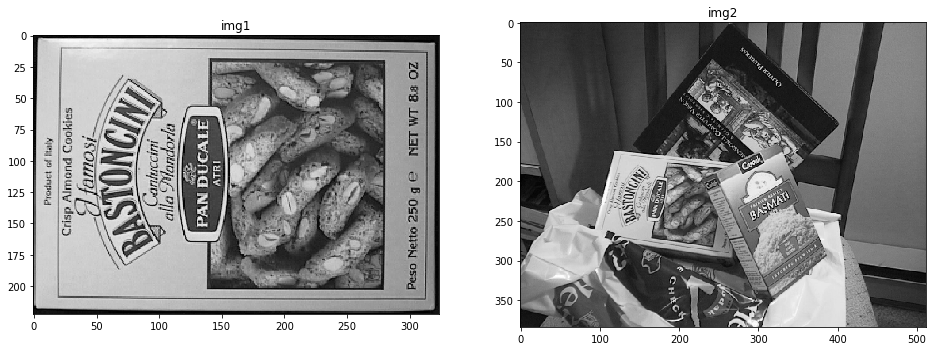

In [2]:
# read images
img1 = cv.imread('resources/box.png', cv.IMREAD_GRAYSCALE)  # queryImage
img2 = cv.imread('resources/box_in_scene.png', cv.IMREAD_GRAYSCALE)  # trainImage
plt.subplot(1,2,1), plt.imshow(img1, 'gray'), plt.title('img1')
plt.subplot(1,2,2), plt.imshow(img2, 'gray'), plt.title('img2')
plt.show()

### Detect and Compute ORB Features
* Create ORB detector
    * `cv.ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]])`

* Detects keypoints and computes the descriptors:
    * `kp, sp = orb.detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]])`

In [3]:
# Initiate ORB detector
# TODO
orb = cv.ORB_create()
# orb = cv.SIFT_create() # SIFT feature

# find the keypoints and descriptors with SIFT (mask=None)
# TODO
kp1, des1 = orb.detectAndCompute(img1, None) # 어떤지점인지 고르고 계산
kp2, des2 = orb.detectAndCompute(img2, None)

### Visualize Features

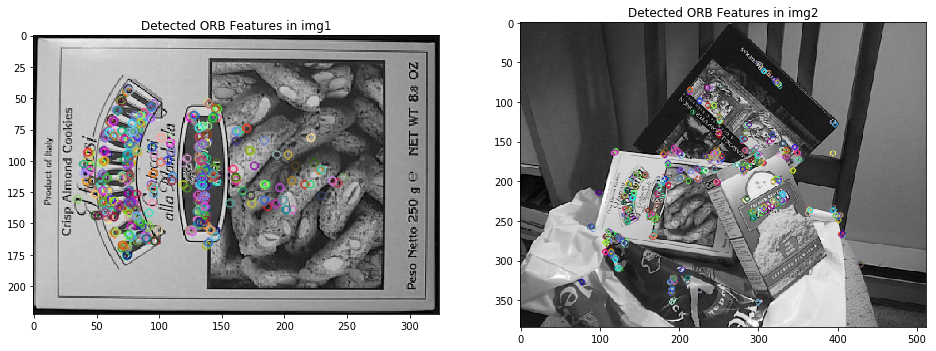

In [4]:
img1_vis = cv.drawKeypoints(img1, kp1, None)
img2_vis = cv.drawKeypoints(img2, kp2, None)

plt.subplot(1,2,1), plt.imshow(img1_vis), plt.title('Detected ORB Features in img1')
plt.subplot(1,2,2), plt.imshow(img2_vis), plt.title('Detected ORB Features in img2')
plt.show()

## Feature matching

* We know how to detect feature points. Next question: How to match them?
    * create the Matcher object
    * compute matches

We will use Brute fouce matcher.
* `cv.BFMatcher([, normType[, crossCheck]])`

In [6]:
# Create Brute fouce matcher
# TODO
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True) # vector space에서 0과 1을 가지고 
                                                     # 숫자가 다른 것의 개수를 세서 비슷한지 안비슷한지 구분
# bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # for SIFT

# TODO
matches = bf.match(des1, des2)

* Draw matched points:
    * `cv.drawMatches(img1, keypoints1, img2, keypoints2, matches1to2, outImg[, matchColor[, singlePointColor[, matchesMask[, flags]]]])`

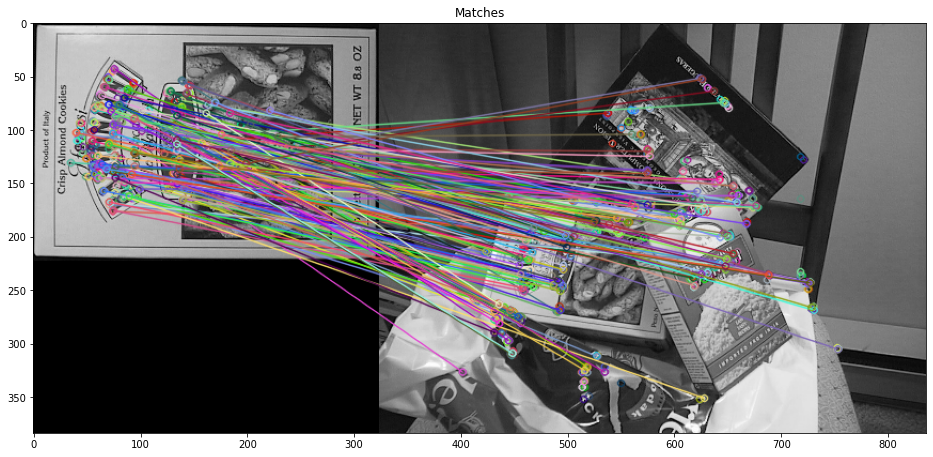

In [131]:
# draw matches
img_matches = cv.drawMatches(img1, kp1, img2, kp2, matches, None)

plt.imshow(img_matches), plt.title('Matches')
plt.show()

## Find Homography

* We have matches now.
    * Can we estimate a transformation now?
    * No. Because of outliers (wrongly matched pairs)


There can be some possible errors while matching which may affect the result.
To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags).
So good matches which provide correct estimation are called inliers and remaining are called outliers.


* Finds a perspective transformation between two planes:
    * `retval, mask = cv.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]])`

We visualize how the images can be transformed using estimated homography.

* Applies a perspective transformation to an image:
    * `dst = cv.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])`

In [ ]:
'''
- RANSAC
homography 4쌍의 매칭 points필요 (Projective transformations Matrix)
random하게 특징점 4점을 Homography를 구해서 warping했을 때 Error가 가장 작은점을 찾을 때 까지 loop를 통해 계산하여 
selected homography를 찾음
'''

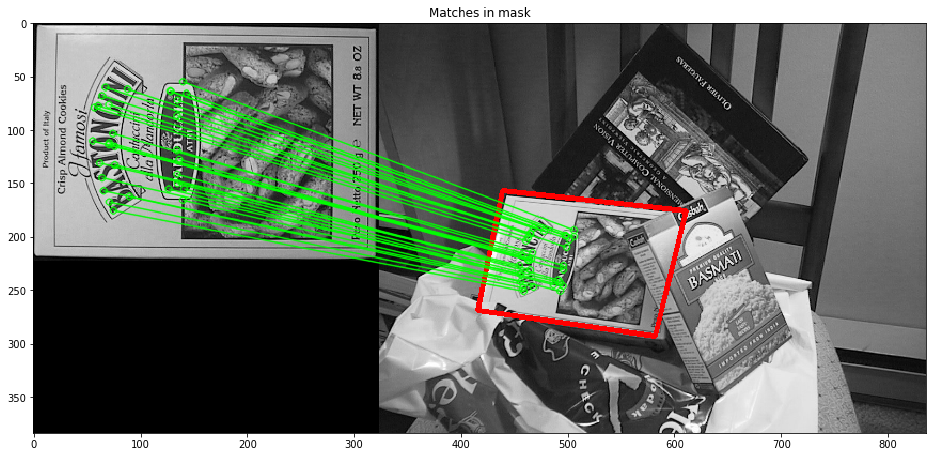

In [16]:
# find homography (method=cv2.RANSAC, ransacReprojThreshold=5.0)
# TODO
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# perspective transform
h, w = img1.shape
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2) # 4개의 가장자리
dst = cv.perspectiveTransform(pts, M) # warping시키는 함수 -> homography에서 4개의 포인트 대응되는점을 찾는다.

# draw box
img2_box = cv.polylines(cv.cvtColor(img2, cv.COLOR_GRAY2BGR), [dst.astype(np.int32)], isClosed = True, color = (255, 0, 0), thickness = 4)
# 빨간색 line을 이어서 그려주는 코드

# draw matches
draw_params = dict(matchColor=(0, 255, 0),   # draw matches in green color
#                    singlePointColor=None,   # match 안이어지면 그리지 마라
                   matchesMask=matchesMask,  # draw only inliers, 매치가 잘된 것만 그려라
                   flags=2) # 싱글 points를 안그리도록 하는 flag
                  
img3 = cv.drawMatches(img1, kp1, img2_box, kp2, matches, None, **draw_params)



plt.imshow(img3), plt.title('Matches in mask')
plt.show()

### Image Warping

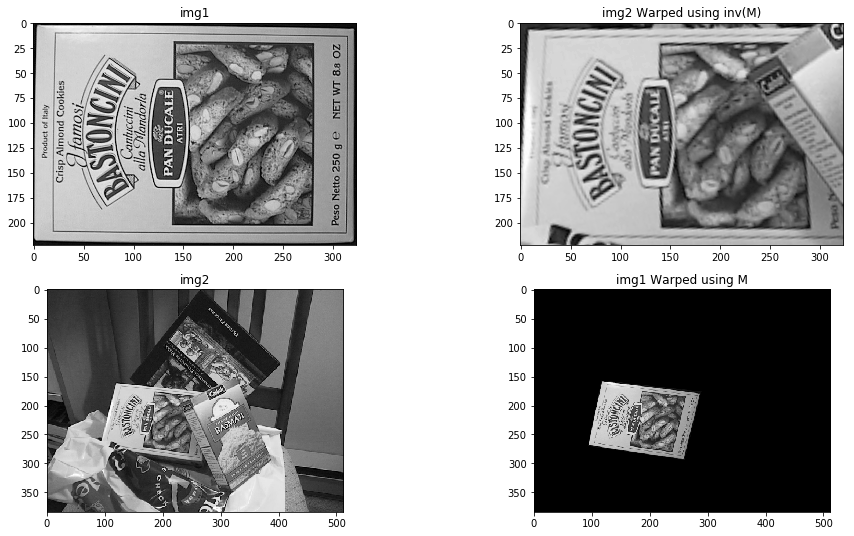

In [15]:
# warp images using homography matrix M
# TODO
# warp img1 to img2 space using M
img1_warped = cv.warpPerspective(img1, M, dsize=(img2.shape[1],img2.shape[0])) # (dsize=(img2.shape[1],img2.shape[0]))
                                                                               # img1을 img2에 warping
# warp img2 to img1 space using inverse of M
img2_warped = cv.warpPerspective(img2, np.linalg.inv(M), dsize=(img1.shape[1],img1.shape[0])) # 반대로 img2에서 img1로 가기위해서 np.linalg.inv 함
                                                                                              # (dsize=(img1.shape[1],img1.shape[0]))
                                                                                              # dsize를 늘리면 나머지 그림도 보인다. img1.shape[1]+300
plt.subplot(2,2,1), plt.imshow(img1, 'gray'), plt.title('img1')
plt.subplot(2,2,2), plt.imshow(img2_warped, 'gray'), plt.title('img2 Warped using inv(M)')
plt.subplot(2,2,3), plt.imshow(img2, 'gray'), plt.title('img2')
plt.subplot(2,2,4), plt.imshow(img1_warped, 'gray'), plt.title('img1 Warped using M')
plt.show()